# Librairies

In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.2.2
Num GPUs Available:  2


In [2]:
import os
use_gpu = True
if use_gpu:
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";
    # The GPU id to use, usually either "0" or "1";
    os.environ["CUDA_VISIBLE_DEVICES"] = "0";

In [11]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.utils.np_utils import to_categorical
from nltk import tokenize

from han.model import HAN

# Functions

In [216]:
def clean_br(s):
    s = re.sub('<br\s?\/>|</{0,1}br>', " . ", s)
    s = re.sub(' *\.[ \.]*', ". ", s)
    return s

def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def visualize_attention_line(attentions_text, decoded_text, show=True, normalize=True, color_paragraph=0):
    token_attention_dic = {}
    if normalize:
        attentions_text = (attentions_text - np.min(attentions_text)) / (np.max(attentions_text) - np.min(attentions_text))
    for token, attention_score in zip(decoded_text, attentions_text):
        #print(token, attention_score)
        token_attention_dic[token] = attention_score

    # Build HTML String to viualize attentions
    html_text = "<div style='font-size: large;border-left-width:10px;border-left-style: solid; border-left-color: {}'>".format(attention2color(color_paragraph))
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention), token)
    html_text += "</div><br>"

    # Display text enriched with attention scores
    if show:
        display(HTML(html_text))
    else:
        return html_text

def visualize_attention(word_att, sent_att, sent_tokenized_review, label_probs):

    # Display Truth and classification 
    html_text = "<p style='font-size: large'><b>Classified as:</b> "
    html_text += max(label_probs, key=label_probs.get)
    html_text += "</p>"
    
    display(HTML(html_text))
    
    # PLOT EMOTION SCORES
    plt.figure(figsize=(5,2))
    plt.bar(np.arange(len(labels)), label_probs.values(), align='center', alpha=0.5, color=['blue', 'red', 'green', 'black', 'cyan', "purple"])
    plt.xticks(np.arange(len(labels)), label_probs.keys())
    plt.ylabel('Scores')
    plt.show()
    
    sent_att = sent_att.squeeze()
    attentions_sent = (sent_att - np.min(sent_att)) / (np.max(sent_att) - np.min(sent_att))

    for i, att in enumerate(sent_att):
        word_att[i] *= att
    word_att = (word_att - np.min(word_att)) / (np.max(word_att) - np.min(word_att))
    
    res = han.word_att_to_df(sent_tokenized_review, word_att)
    res['sentence_att'] = pd.Series(sent_att.squeeze())

    # Build HTML String to viualize attentions
    html_text = "<hr><p style='font-size: large'><b>Text:</b></p>"
    
    for i, att in enumerate(attentions_sent):
        decoded_text = res['word_att'][i].keys()
        attentions_text = res['word_att'][i].values()
        
        html_text += visualize_attention_line(attentions_text, decoded_text, 
                                          show=False, normalize=False, color_paragraph=att)
    # Display text enriched with attention scores 
    display(HTML(html_text))





# Data

In [238]:
#Importing the dataset

dataset = pd.read_csv('../IMDB Review - LSTM with Attention/imdb_master.csv', encoding = "ISO-8859-1")
dataset.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [239]:
dataset = dataset.drop(['Unnamed: 0', 'file'], axis = 1)
dataset = dataset[dataset.label != 'unsup']
dataset['label'] = dataset['label'].map({'pos': 1, 'neg': 0})
dataset['review'] = dataset['review'].apply(clean_br)

In [240]:
texts = []
reviews = []
labels = []
for idx in dataset.index:
    texts.append(dataset.review[idx])
    sentences = tokenize.sent_tokenize(dataset.review[idx])
    reviews.append(sentences)
    labels.append(dataset.label[idx])

In [227]:
MAX_FEATURES = 120000 # how many unique words to use (i.e num rows in embedding vector)

In [228]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(texts)

In [241]:
MAX_LEN = 100 # Maximum length for texts
MAX_SENT = 20

data = np.zeros((len(texts), MAX_SENT, MAX_LEN), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENT:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                try:
                    if k < MAX_LEN and tokenizer.word_index[word] < MAX_FEATURES:
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
                except:
                    pass

In [242]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Total 123681 unique tokens.
Shape of reviews (data) tensor: (50000, 20, 100)
Shape of sentiment (label) tensor: (50000, 2)


In [243]:
validation_split = 0.2

In [244]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(validation_split * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

print('Number of positive and negative reviews in training and validation set')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))

Number of positive and negative reviews in training and validation set
[19993. 20007.]
[5007. 4993.]


In [245]:
glove_dir = '../BIGRU-Attention_visualized/glove.840B.300d/'
EMBEDDING_FILE = 'glove.840B.300d.txt'
EMB_SIZE = 300

# Reading file
embeddings_index = {}
f = open(os.path.join(glove_dir, EMBEDDING_FILE))
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        pass
f.close()

# Embedding matrix creation
embedding_matrix = np.random.random((len(word_index) + 1, EMB_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
embedding_matrix.shape

(123682, 300)

# HAN model

In [246]:
# Initialization
han = HAN(embedding_matrix, 
          max_sent_length=MAX_LEN, 
          max_sent_num=MAX_SENT, 
          word_embed_dim=100, 
          sent_embed_dim=100)
han.print_summary()

Word Level
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 300)          37104600  
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 100, 100)          105600    
_________________________________________________________________
time_distributed_18 (TimeDis (None, 100, 100)          10100     
_________________________________________________________________
word_attention (Attention)   (None, 100)               10200     
Total params: 37,230,500
Trainable params: 125,900
Non-trainable params: 37,104,600
_________________________________________________________________
Sentence Level
Model: "model_45"
______________________________________________________________

In [247]:
# Training
checkpoint_path = './'
han.train_model(checkpoint_path, x_train, y_train, x_val, y_val, 
                batch_size=20, epochs=5)

Epoch 1/10
2000/2000 [==============================] - ETA: 0s - loss: 0.4926 - acc: 0.7438
Epoch 00001: val_loss improved from inf to 0.33508, saving model to ./
INFO:tensorflow:Assets written to: ./assets
2000/2000 [==============================] - 152s 76ms/step - loss: 0.4926 - acc: 0.7438 - val_loss: 0.3351 - val_acc: 0.8564
Epoch 2/10
2000/2000 [==============================] - ETA: 0s - loss: 0.3162 - acc: 0.8655
Epoch 00002: val_loss improved from 0.33508 to 0.31072, saving model to ./
INFO:tensorflow:Assets written to: ./assets
2000/2000 [==============================] - 153s 76ms/step - loss: 0.3162 - acc: 0.8655 - val_loss: 0.3107 - val_acc: 0.8673
Epoch 3/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.2986 - acc: 0.8750
Epoch 00003: val_loss improved from 0.31072 to 0.30044, saving model to ./
INFO:tensorflow:Assets written to: ./assets
2000/2000 [==============================] - 150s 75ms/step - loss: 0.2987 - acc: 0.8750 - val_loss: 0.3004 - val_ac

KeyboardInterrupt: 

# Prediction and explaination

In [284]:
line=4

# Prediction
X = x_val[line:line+1]
truth = y_val[line]
pred = han.model.predict(X)[0]
print("Truth : ", truth[1])
print("Pred : ", pred[1])

Truth :  1.0
Pred :  0.97705984


In [285]:
# Explaiantion by sentence
sent_att = han.show_sent_attention(X)
sent_tokenized_reviews = [tokenizer.sequences_to_texts(X[0])]
res = han.sent_att_to_df(sent_tokenized_reviews, sent_att)
z = {}
for el in res['sent_att'][0]:
    z = {**z, **el}
df = pd.DataFrame(z.items())
df.iloc[:, 1] = round(df.iloc[:, 1]*100, 1)
df

The following Variables were used a Lambda layer's call (lambda_47), but
are not present in its tracked objects:
  <tf.Variable 'sent_attention_6/W:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'sent_attention_6/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'sent_attention_6/context_vector:0' shape=(100,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


,0,1
0,stephen sondheim's sweeney todd the demon barb...,1.2
1,although it swept virtually every award imagin...,5.0
2,fortunately however the play then went on tour...,4.7
3,the result is a remarkable capture of the play...,5.8
4,there is however a flaw,3.5
5,simply stated stage plays do not film very wel...,6.3
6,sweeney todd is no exception,1.3
7,seen on film it has a stand and sing quality a...,7.0
8,taking this stage play on film effect into con...,15.8
9,lansbury is astonishing a mixture of silliness...,11.3


In [286]:
# Explaiantion by word
X = x_val[line]
word_att = han.show_word_attention(X)
sent_tokenized_review = tokenizer.sequences_to_texts(X)

res = han.word_att_to_df(sent_tokenized_review, word_att)
res['sentence_att'] = round(pd.Series(sent_att.squeeze())*100,1)
res

The following Variables were used a Lambda layer's call (lambda_48), but
are not present in its tracked objects:
  <tf.Variable 'word_attention_6/W:0' shape=(100, 100) dtype=float32>
  <tf.Variable 'word_attention_6/bias:0' shape=(100,) dtype=float32>
  <tf.Variable 'word_attention_6/context_vector:0' shape=(100,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


,word_att,review,sentence_att
0,"{'stephen': 0.05987169, 'sondheim's': 0.006701...","[stephen, sondheim's, sweeney, todd, the, demo...",1.2
1,"{'although': 0.0492706, 'it': 0.06542231, 'swe...","[although, it, swept, virtually, every, award,...",5.0
2,"{'fortunately': 0.3227381, 'however': 0.187590...","[fortunately, however, the, play, then, went, ...",4.7
3,"{'the': 0.008776995, 'result': 0.064711675, 'i...","[the, result, is, a, remarkable, capture, of, ...",5.8
4,"{'there': 0.03423464, 'is': 0.090707935, 'howe...","[there, is, however, a, flaw]",3.5
5,"{'simply': 0.02613682, 'stated': 0.014920265, ...","[simply, stated, stage, plays, do, not, film, ...",6.3
6,"{'sweeney': 0.09134657, 'todd': 0.05076817, 'i...","[sweeney, todd, is, no, exception]",1.3
7,"{'seen': 0.010975278, 'on': 0.0054082233, 'fil...","[seen, on, film, it, has, a, stand, and, sing,...",7.0
8,"{'taking': 0.008173524, 'this': 0.018405082, '...","[taking, this, stage, play, on, film, effect, ...",15.8
9,"{'lansbury': 0.03321199, 'is': 0.028896136, 'a...","[lansbury, is, astonishing, a, mixture, of, si...",11.3


In [287]:
sent_nb = 1

df = pd.DataFrame(res['word_att'][sent_nb].items())
df.iloc[:, 1] = round(df.iloc[:, 1]*100, 1)

decoded_text = df.iloc[:, 0].values
attentions_text = df.iloc[:, 1].values
visualize_attention_line(attentions_text, decoded_text)

df

,0,1
0,although,4.9
1,it,6.5
2,swept,6.3
3,virtually,12.1
4,every,5.9
5,award,3.1
6,imaginable,15.0
7,the,0.9
8,box,1.2
9,office,0.9


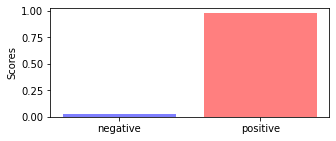

In [288]:
labels = ['negative', 'positive']
label_probs = dict(zip(labels, pred))

visualize_attention(word_att, sent_att, sent_tokenized_review, label_probs)